In [1]:
#import useful libraries
import requests, time, datetime#, json
import numpy as np
import matplotlib.cm as cm
from pysolar.solar import *
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
import pytz
from random import choice
import io
import PIL
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#from pylab import *

In [2]:
#define custom colourmaps

cc = 1/255 #colour coefficient: matplotlib accepts values between 0 and 1
           #but RGB values are usually between 0 and 255.

#wind colourmap
cdict = {'red':    [[0.0, 94*cc, 94*cc],
                    [0.2, 94*cc, 94*cc],
                    [0.4, 83*cc, 83*cc],
                    [0.6, 44*cc, 44*cc],
                    [0.8, 64*cc, 64*cc],
                    [1.0, 94*cc, 94*cc]],
         
          'green': [[0.0, 143*cc, 143*cc],
                    [0.2, 94*cc, 94*cc],
                    [0.4, 64*cc, 64*cc],
                    [0.6, 77*cc, 77*cc],
                    [0.8, 146*cc, 146*cc],
                    [1.0, 143*cc, 143*cc]],
         
          'blue':  [[0.0, 255*cc, 255*cc],
                    [0.2, 255*cc, 255*cc],
                    [0.4, 255*cc, 255*cc],
                    [0.6, 255*cc, 255*cc],
                    [0.8, 255*cc, 255*cc],
                    [1.0, 255*cc, 255*cc]]}


wind_cmap = LinearSegmentedColormap('wind_cmap', segmentdata=cdict, N=256)

#solar elevation colourmap
cdict = {'red':    [[0.0, 8*cc, 8*cc],
                    [0.2, 75*cc, 75*cc],
                    [0.3, 21*cc, 21*cc],
                    [0.4, 253*cc, 253*cc],
                    [0.45, 252*cc, 252*cc],
                    [0.5, 237*cc, 237*cc],
                    [1.0, 80*cc, 80*cc]],
         
         'green':  [[0.0, 24*cc, 24*cc],
                    [0.2, 61*cc, 61*cc],
                    [0.3, 40*cc, 40*cc],
                    [0.4, 94*cc, 94*cc],
                    [0.45, 227*cc, 227*cc],
                    [0.5, 247*cc, 247*cc],
                    [1.0, 184*cc, 184*cc]],
         
         'blue':   [[0.0, 58*cc, 58*cc],
                    [0.2, 96*cc, 96*cc],
                    [0.3, 82*cc, 82*cc],
                    [0.4, 83*cc, 83*cc],
                    [0.45, 115*cc, 115*cc],
                    [0.5, 252*cc, 252*cc],
                    [1.0, 231*cc, 231*cc]]}

day_night = LinearSegmentedColormap('day_night', segmentdata=cdict, N=256)

In [4]:
#define functions

def get_weather_data(place, API_key):
    params = {'q':place, 'appid':API_key}
    URL = "http://api.openweathermap.org/data/2.5/weather?"
    response = requests.get(URL, params=params)
    data = response.json()
    
    if response.status_code != 200:
        raise Exception(("Error: " + str(response.status_code)))
    
    else:
        return(data)

def get_season(data):
    #returns the season in the northern hemesphere for a given date
    time = int(data["dt"])
    date = datetime.datetime.utcfromtimestamp(time)
    year = date.year
    winter_start = datetime.datetime(year, 1, 1) 
    spring_start = datetime.datetime(year, 3, 1)
    summer_start = datetime.datetime(year, 6, 1)
    autumn_start = datetime.datetime(year, 9, 1)
    
    if winter_start <= date < spring_start:
        return ("winter")
    elif spring_start <= date < summer_start:
        return ("spring") 
    elif summer_start <= date < autumn_start:
        return ("summer")
    else:
        return ("autumn")

def get_solar_elevation(data):
    #returns the angle of the sun above the horizon (and therefor light levels;
    #day, night, twilight) at the timestamp of the imput data
    
    time = data["dt"]
    date = datetime.datetime.fromtimestamp(time)
    date = date.replace(tzinfo=pytz.UTC) #replaces the unaware datetime object "date" with an aware equivelent
    elevation = get_altitude(53.5998, 1.9301, date)
    
    return(elevation)

def get_cloudcover(data):
    #returns the cloudcover as a percentage
    
    try:
        cloudcover = data["clouds"]["all"]
        
    except KeyError:
        print ("exception")
        cloudcover = 0.0
    
    return(cloudcover)
    
def get_rain(data):
    #returns the rainfall for the past hour in mm
    
    try:
        rain = data["rain"]["1h"]
        
    except KeyError:
        rain = 0.0
        
    return(rain)

def get_temperature(data):
    #returns the atmospheric temperature 
    
    temp = data["main"]["temp"]
    temp = temp - 273.15 #converts from kelvin to celcius
    
    return(temp)

def get_wind(data):
    
    try:
        speed = data["wind"]["speed"]
        direction = data["wind"]["deg"]
        wind = [speed,direction]
    
    except KeyError:
        wind = [0.0, 0.0]
    
    return (wind)
    
def _norm(max_val, min_val, value):
    
    if value >= max_val:
        return 1.0
    elif value <= min_val:
        return 0.0
    else:
        return (value - min_val)/(max_val - min_val)


In [5]:
#get_weather_data("Marsden", "0f3b84c408fd239d3d09d637059518ae")

In [6]:
#set colourmaps for each perameter
cloudcover_cmap = cm.get_cmap('Greys')
temperature_cmap = cm.get_cmap('coolwarm')
solar_elevation_cmap = day_night
windspeed_cmap = wind_cmap
rain_cmap = cm.get_cmap('Blues')

In [7]:



def get_image(data):

    #get season colour
    season = "autumn"

    if season == "spring":
        season_col = [40.0*cc, 143.0*cc, 45.0*cc] #green
    elif season == "summer":
        season_col = [242.0*cc, 158.0*cc, 22.0*cc] #orange
    elif season == "autumn":
        season_col = [151.0*cc, 50.0*cc, 161.0*cc] #purple
    else:
        season_col = [242.0*cc,248.0*cc,255.0*cc]#[250*cc, 239*cc, 239*cc] #white

    #get solar elevation colour
    sol_el_col = solar_elevation_cmap(_norm(54, -54, get_solar_elevation(data)))

    #get cloudcover colour
    cloud_col = cloudcover_cmap(_norm(100, 0, get_cloudcover(data)))

    #get temperature colour
    temp_col = temperature_cmap(_norm(35,-10, get_temperature(data)))

    #get rain colour
    rain_col = rain_cmap(_norm(8,0, get_rain(data)))

    #get wind colour
    wind = get_wind(data)
    wind_col = windspeed_cmap(_norm(360, 0, wind[1]))
    wind_col = rgb_to_hsv(wind_col[0:3])
    wind_col[1] = wind_col[1]*_norm(30, 0, wind[0])
    wind_col = hsv_to_rgb(wind_col)
    
    #create numpy array representing image
    colour_im_array = np.zeros([128,192,3])
    colour_im_array[0:64,0:64] = wind_col
    colour_im_array[0:64,64:128] = sol_el_col[0:3]
    colour_im_array[0:64,128:192] = cloud_col[0:3]
    colour_im_array[64:128,0:64] = temp_col[0:3]
    colour_im_array[64:128,64:128] = rain_col[0:3]
    colour_im_array[64:128,128:192] = season_col
    
    #convert array to image
    im = PIL.Image.fromarray(np.uint8(colour_im_array*255))
    
    print(temp_col)
    print(season_col)
    
    return im

C:\ProgramData\Anaconda3\lib\site-packages\pysolar\solartime.py:112: UserWarning: I don't know about leap seconds after 2018
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


(0.8049647588235295, 0.8516661605568627, 0.9261650744313725, 1.0)
[0.592156862745098, 0.19607843137254902, 0.6313725490196078]


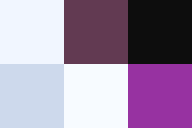

In [8]:
get_image(get_weather_data("Horbury", "0f3b84c408fd239d3d09d637059518ae"))